# Running EM on the birdsong corpus

## Getting set up

In [1]:
import markhov
import em
import numpy as np
import pandas as pd
%pylab inline
import seaborn as sns
from florisplotlib import *

Populating the interactive namespace from numpy and matplotlib


Read in the birdsong corpus

In [2]:
f=open('../corpus/cath8.txt','r')
corpus = f.readlines()
f.close()
corpus = [line.rstrip('\n') for line in corpus]


Create a transition grammar for the corpus

In [3]:
trans = {'[':[]}
for s in corpus:
    s=['[']+s.split(' ')
    for i in range(1,len(s)):
        trans[s[i-1]]=trans.get(s[i-1],[])
        if s[i] not in trans[s[i-1]]:
            trans[s[i-1]].append(s[i])


Operations FSA

In [4]:
ops = {'S':[('NotCL','mg')], # from start we have to merge
       'NotCL':[('NotCL','mg'),('NotCL','copy'), # this state is the state in which the last "special" operation was *not* Clear. Either we've done none or the last was copy. From here we can do everything including end
               ('CLEAR_S','clear'), # go here to clear the buffer
               ('F','end') # go here to end
           ],
       'CLEAR_S':[('CLEAR','mg')], # this is where we've just cleared. Buffer is empty so you can only Merge
       'CLEAR':[('CLEAR','mg'), # the last special op was Clear so we can Copy or Merge.
                ('NotCL','copy') # if we Copy, the last special op was Copy so go to NotCL
            ],
       'F':[] #final state
   }


## Expectation Maximisation time!

In [5]:
n = 10 # number of EM iterations to do

In [6]:
history=em.em(corpus,trans,ops,n) # run EM

### Display the results

Make the rules into a simpler list

In [7]:
rules=[]
for lhs in ops:
    for (rhs,e) in ops[lhs]:
        rules.append(('%s->%s %s'%(lhs,e,rhs),(lhs,rhs,e)))

Put them and their updating probabilities into a table

In [8]:
tab=[]
for (rule,(lhs,rhs,e)) in rules:
    thisrule={' rule':rule}
    for i in range(n):
        p=history[i]['fsa'][lhs][(rhs,e)]
        thisrule["p.iteration%03d"%i]=p
    tab.append(thisrule)

Use pandas to make the table into a datafram

In [9]:
df = pd.DataFrame(tab)

In [10]:
df

,rule,p.iteration000,p.iteration001,p.iteration002,p.iteration003,p.iteration004,p.iteration005,p.iteration006,p.iteration007,p.iteration008,p.iteration009
0,S->mg NotCL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,CLEAR->mg CLEAR,-0.685624,-0.966680,-1.080059,-1.239628,-1.431987,-1.556711,-1.698315,-1.854403,-2.020109,-2.196567
2,CLEAR->copy NotCL,-0.700728,-0.478590,-0.414872,-0.341775,-0.272904,-0.236772,-0.202106,-0.170250,-0.142302,-0.117865
3,CLEAR_S->mg CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,NotCL->mg NotCL,-3.540089,-0.550847,-0.372487,-0.270388,-0.216446,-0.189882,-0.176216,-0.167665,-0.162489,-0.159609
5,NotCL->copy NotCL,-0.809758,-2.982535,-3.626093,-4.236325,-4.785061,-5.203516,-5.591448,-6.105497,-6.624899,-7.141046
6,NotCL->clear CLEAR_S,-1.166708,-1.756424,-2.213469,-2.752572,-3.318388,-3.846157,-4.290021,-4.695903,-5.060458,-5.336451
7,NotCL->end F,-1.538824,-1.608373,-1.742738,-1.840788,-1.896723,-1.923570,-1.937050,-1.944910,-1.949783,-1.952505


In [11]:
df.to_csv('ops_%s.csv'%('oct_23_2016_cath8')) # print to file

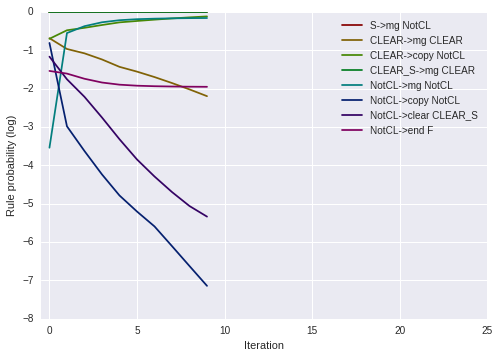

In [12]:
ncol,_ = df.shape
colors = get_colors(ncol)
for i,row in df.iterrows():
    col = colors[i]
    plot(range(n),[ row["p.iteration%03d"%i] for i in range(n) ],'-',color=col,label=row[" rule"])
legend()
xlim(-.5,n+15)
xlabel("Iteration")
ylabel("Rule probability (log)")

Same for the transitions

In [13]:
bigrams=[]
for lhs in trans:
    for rhs in trans[lhs]:
        bigrams.append(('%s,%s'%(lhs,rhs),(lhs,rhs)))

In [14]:
tab=[]
for (bi,(lhs,rhs)) in bigrams:
    thisrule={' bigram':bi}
    for i in range(n):
        p=history[i]['trans_probs'][lhs][rhs]
        thisrule["p.iteration%03d"%i]=p
    tab.append(thisrule)

In [15]:
df_bis = pd.DataFrame(tab)

In [16]:
df_bis

,bigram,p.iteration000,p.iteration001,p.iteration002,p.iteration003,p.iteration004,p.iteration005,p.iteration006,p.iteration007,p.iteration008,p.iteration009
0,"aua,aiz",-1.930226,-2.437935,-2.499848,-2.572410,-2.790462,-2.963085,-2.999655,-3.010493,-3.016556,-3.020216
1,"aua,ats",-2.076029,-0.492007,-0.472972,-0.524241,-0.729989,-0.892208,-0.925138,-0.934173,-0.938944,-0.941850
2,"aua,aua",-3.622181,-4.592838,-3.858633,-2.562138,-1.378127,-1.004049,-0.947511,-0.932427,-0.924429,-0.919626
3,"aua,amb",-8.693890,-2.843400,-2.905313,-2.977875,-3.195927,-3.368550,-3.405120,-3.415958,-3.422022,-3.425681
4,"aua,aje",-2.228726,-3.536548,-3.598461,-3.671022,-3.889074,-4.061697,-4.098267,-4.109105,-4.115169,-4.118828
5,"aua,aiy",-1.944318,-2.843400,-2.905313,-2.977875,-3.195927,-3.368550,-3.405120,-3.415958,-3.422022,-3.425681
6,"aua,aib",-2.028143,-3.536548,-3.598461,-3.671022,-3.889074,-4.061697,-4.098267,-4.109105,-4.115169,-4.118828
7,"aua,ban",-3.836984,-3.536548,-3.598461,-3.671022,-3.889074,-4.061697,-4.098267,-4.109105,-4.115169,-4.118828
8,"aua,awi",-2.088607,-3.536548,-3.598461,-3.671022,-3.889074,-4.061697,-4.098267,-4.109105,-4.115169,-4.118828
9,"aua,abu",-2.517231,-3.536548,-3.598461,-3.671022,-3.889074,-4.061697,-4.098267,-4.109105,-4.115169,-4.118828


In [17]:
df_bis.to_csv('trans_%s.csv'%('oct_23_2016_cath8'))

### Calculate the log likelihood of the corpus given the trained grammar

This is the ll of the corpus at the end of training:

In [18]:
# parse the corpus
parsed_corpus=em.parse_corpus(corpus,trans,ops)

In [19]:
em.ll_corpus(parsed_corpus,history[-1]['trans_probs'],history[-1]['fsa'])

-4689.9872533019625

Make a dataframe of the LL of the corpus throughout training:

In [20]:
tab=[]
for i in range(n):
    this_iter={'iteration':i,
               'likelihood':em.ll_corpus(parsed_corpus,history[i]['trans_probs'],history[i]['fsa'])}
    tab.append(this_iter)

In [21]:
df_lls=pd.DataFrame(tab)

In [22]:
df_lls

,iteration,likelihood
0,0,-9564.472696
1,1,-5131.872177
2,2,-4948.551733
3,3,-4833.990194
4,4,-4766.339443
5,5,-4735.378088
6,6,-4712.423253
7,7,-4700.105865
8,8,-4694.535292
9,9,-4691.560763


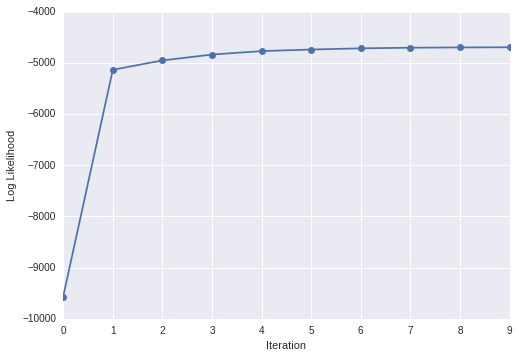

In [23]:
plot(df_lls["iteration"],df_lls["likelihood"],'o-')
xlabel("Iteration")
ylabel("Log Likelihood")